# Machine Learning for physics

# TP2: Linear Regression

In this notebook we deal with linear regression and its regularizations Ridge and LASSO. These methods are applied to polynomial function fitting and the diabete dataset.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

## Generating data

We generate samples from a sine function with random noise (that follows a normal distribution).

In [2]:
# Generating data
nb_measurements = 100
sig = 0.5
X = np.random.random_sample(size=nb_measurements)
Y = np.sin(6*X) + sig*np.random.normal(size=nb_measurements)

In [3]:
print(np.shape(X), np.shape(Y))

(100,) (100,)


Let's plot the data :

Text(0.5, 1.0, 'Data')

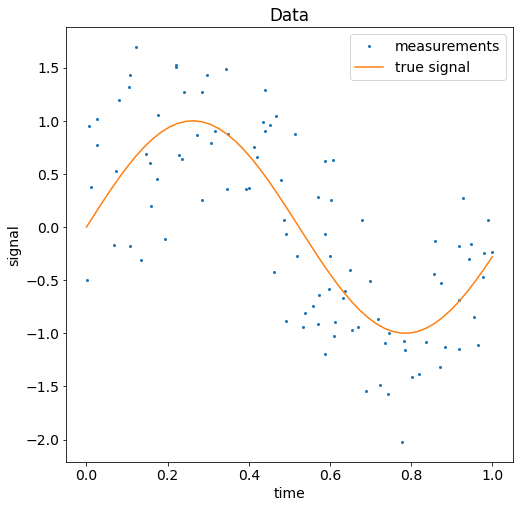

In [4]:
# Plotting the data
plt.plot(X, Y, "o", markersize=2, label="measurements")
x=np.linspace(0, 1)
plt.plot(x, np.sin(6*x), label="true signal")
plt.xlabel("time")
plt.ylabel("signal")
plt.legend()
plt.title("Data")

and build our training and test sets :

In [5]:
#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,
                                                 random_state=12)

Note: `train_test_split` automatically shuffles the data.

We will now try to fit the data with polynomial functions. Our loss function will be the Root Mean Squared Error (RMSE)

(What about MAE ? -- It should be similar since there is not really any outlier.)

### First order polynomial

We create an array containing the powers of X.

In [6]:
# expand the X array into a matrix (len(X), order=k) 
# with row (x_i^0, x_i ^1, ... x_i^k)
def X_powers(X, order):
    """
    Return an array of shape (len(X), order) 
    where the i-th column is X**i
    
    arg X: a column vector
    arg order: the highest power of X
    """
    power_list = np.arange(order)
    res = np.empty((len(X), order+1))
    for k in range(order+1):
        res[:, k] = X**k
    return res

One loop remains... Yet we expect the order to be relatively small, since complex models tend to overfit. 

In [7]:
# Toy array to check the function
a_toy = np.array([1., 2., 3., 4.])
max_order = 2
a_powers = X_powers(a_toy, max_order)
print(a_powers)
np.shape(a_powers)

[[ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]]


(4, 3)

We write a function that compute f(X), f a polynomial function.

In [8]:
w_toy = np.array([5., 2., 0.5])
print(w_toy)
np.shape(w_toy)

[5.  2.  0.5]


(3,)

In [9]:
print(np.matmul(a_powers, w_toy))

[ 7.5 11.  15.5 21. ]


In [10]:
assert (a_powers @ w_toy).all() == np.matmul(a_powers, w_toy).all()

In [11]:
def polynomial(a, coefs):
    """
    Compute a polynomial function for a list of values.
    
    arg 'a': a column aray containing the x values;
    arg 'coef': the polonomial coefficients
    
    return: an array of the shape of 'a'
    """
    order = len(coefs)-1
    a_powers = X_powers(a, order)
    return a_powers @ coefs

In [12]:
assert polynomial(a_toy, w_toy).all() == (a_powers @ w_toy).all()

Now we do a linear regression over the training set.

In [13]:
def compute_OLS_coef(x_powers, y, order):
    return np.linalg.inv(x_powers.T@x_powers) @ x_powers.T @y

In [14]:
linear_order = 1
X_train_powers = X_powers(X_train, linear_order)
w = compute_OLS_coef(X_train_powers, y_train, linear_order)
print(w)

[ 0.91395214 -1.94932957]


We build a more generic function that does all the previous steps.

In [15]:
def OLS_regression(x_train, y_train, x_estimate, order):
    """
    Return a polynomial fit of the data ('x_train', 'y_train'), evaluated over 'x_estimate'. 
    
    arg 'x_train', 'y_train': two column arrays; they are the data used to build the regression
    arg 'x_estimate': a list of points where the polynomial fit is evaluated;
    arg 'order': the order of the polynomial function;
    
    return: a list, the fit function values taken over 'x_estimate'
    """
    x_powers = X_powers(x_train, order)
    w = compute_OLS_coef(x_powers, y_train, order)
    return polynomial(x_estimate, w)

Let us look at the result:

Text(0.5, 1.0, 'Linear regression')

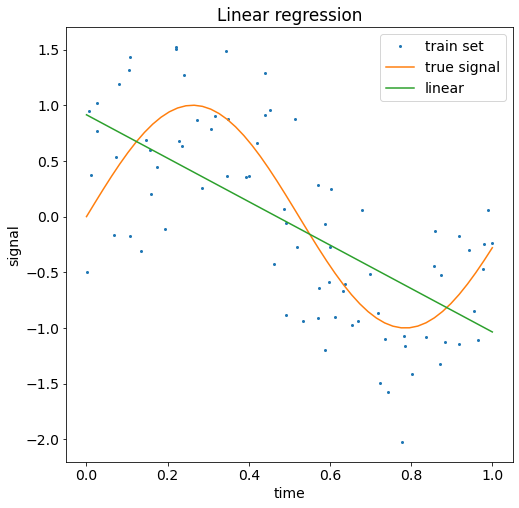

In [16]:
plt.plot(X_train, y_train, "o", markersize=2, label="train set")
x=np.linspace(0, 1)
plt.plot(x, np.sin(6*x), label="true signal")
plt.plot(x, OLS_regression(X_train, y_train, x, linear_order), label="linear")
plt.xlabel("time")
plt.ylabel("signal")
plt.legend()
plt.title("Linear regression")

Let's try higher-order polynomials.

Text(0.5, 1.0, 'Polynomial regressions to several orders')

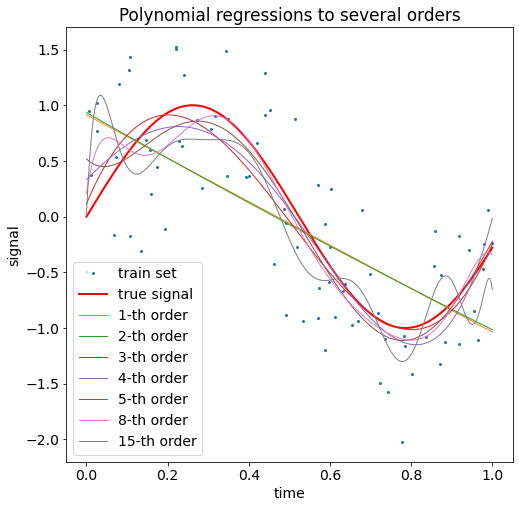

In [17]:
x=np.linspace(0, 1, 500)
plt.plot(X_train, y_train, "o", markersize=2, label="train set")
plt.plot(x, np.sin(6*x), linewidth=2, color='red', label="true signal")
for order in [1, 2, 3, 4, 5, 8, 15]:
    plt.plot(x, OLS_regression(X_train, y_train, x, order),linewidth=1, 
             label="{}-th order".format(order))
plt.xlabel("time")
plt.ylabel("signal")
plt.legend()
plt.title("Polynomial regressions to several orders")

*Comment:* High-order polynomial functions overfit the training data and add artificial variations. First and second order polynomials miss the characteristic variations of the true signal. $3^{rd}$ and $4^{th}$ order seem to do a decent job over this interval.

### RMSE (Root Mean Squared Error)

Our loss function.

In [18]:
print(np.sum(a_toy))

10.0


In [19]:
def rmse(y_est, y_true):
    """
    Return the Root Mean Square Error of function 'func' over the dataset ('x', 'y')
    """
    assert len(y_est) == len(y_true)
    return np.sqrt(((y_est - y_true)**2).mean())

In [20]:
max_order = 20
rmse_list = np.empty((max_order, 2))
for order in range(max_order):
    rmse_list[order, 0] = rmse(OLS_regression(X_train, y_train, X_train, order), y_train)
    rmse_list[order, 1] = rmse(OLS_regression(X_train, y_train, X_test, order), y_test)    

Text(0, 0.5, 'RMSE')

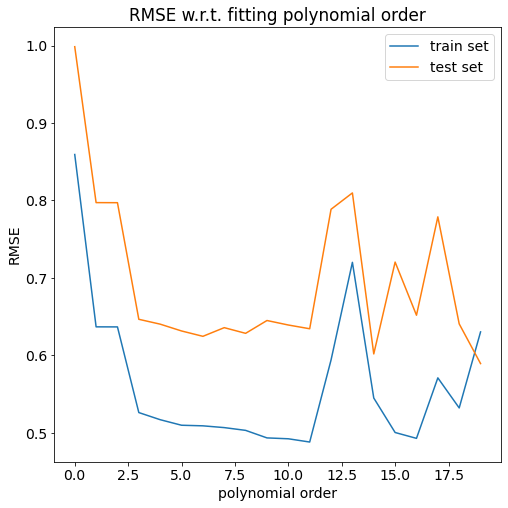

In [21]:
# Plot the risk function
plt.plot(np.arange(max_order), rmse_list[:, 0], label="train set")
plt.plot(np.arange(max_order), rmse_list[:, 1], label="test set")
plt.title("RMSE w.r.t. fitting polynomial order")
plt.legend()
plt.xlabel("polynomial order")
plt.ylabel("RMSE")

*Comment* : The performance on both the training and test sets improves up to the $3^{rd}$ order, and gets really chaotic from the $12^{th}$ order. The train set performance stays pretty much the same for polynomials of order between 3 and 10; the test set performance is best for $3^{rd}$ to $5^{th}$ order polynomials. There the distance  between both curves is relativement small -> little overfitting. This is consistant with the rough guess above.

## Ridge regression

We now use regularization on our polynomial regression. Let's start with the L2-norm regularizer "Ridge".

In [22]:
# Test
linear_order = 1
weight_L2 = 1.
X_pows = X_powers(X_train, linear_order)
assert np.shape((X_pows.T)@X_pows) == np.shape(np.identity(linear_order+1))
print(np.shape(np.identity(linear_order+1)))
arr1 = (X_pows.T)@X_pows + weight_L2*np.identity(linear_order+1)
arr2 = np.linalg.inv(arr1)
arr3 = (X_pows.T)@y_train
print(np.shape((X_pows.T)@y_train))
w = arr2@arr3
print(w)

(2, 2)
(2,)
[ 0.75845733 -1.65838645]


In [23]:
def compute_ridge_coef(X, Y, order, weight):
    """
    Return the coefficients of a polynomial regression of order 'order' using Ridge Regression.
    
    arg X: samples array; shape (N samples, p features)
    arg Y: label array; shape (N samples, )
    arg order: the order of the polynomial function
    arg weight: the coefficient of the L2 norm in the Ridge Regression
    
    return: an array of shape (order, )
    """
    X_pows = X_powers(X, order)
    w_ridge = np.linalg.inv((X_pows.T)@X_pows + weight*np.identity(order+1))@(X_pows.T)@Y
    return w_ridge

In [24]:
assert w.all() == compute_ridge_coef(X_train, y_train, linear_order, weight_L2).all()

Text(0.5, 1.0, 'Polynomial ridge regression')

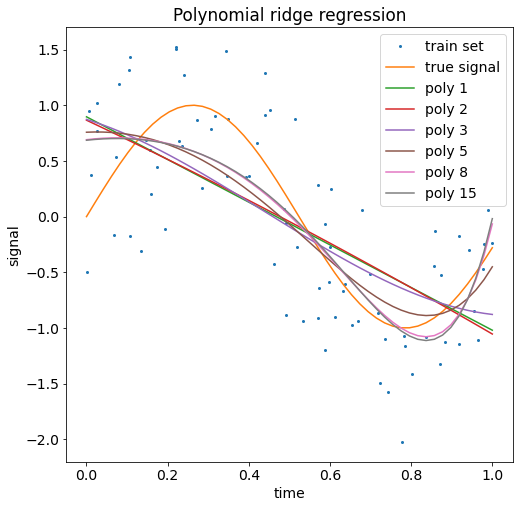

In [25]:
# Plot:
x=np.linspace(0, 1)
weight_L2 = 0.1
plt.plot(X_train, y_train, "o", markersize=2, label="train set")
plt.plot(x, np.sin(6*x), label="true signal")
for order in [1, 2, 3, 5, 8, 15]:
    w = compute_ridge_coef(X_train, y_train, order, weight_L2)
    plt.plot(x, polynomial(x, w), label="poly {}".format(order))
plt.xlabel("time")
plt.ylabel("signal")
plt.legend()
plt.title("Polynomial ridge regression")

Now all the polynomial functions underfit the data... We can find the best `weight_L2` value for each polynomial using cross-validation, but it is more convenient to employ `sklearn` built-in Ridge model.

## Numerical experiments with Ridge and Lasso

Here we limit ourselves to linear regressions.

In [26]:
from __future__ import print_function
print(__doc__)

Automatically created module for IPython interactive environment


In [27]:
# This code is modified from plot_cv_diabetes.py in the skit-learn documentation
# and plot_ridge_path.py

#import seaborn
from sklearn import datasets, linear_model
from sklearn.linear_model import Ridge, Lasso

# Load Training Data set with 200 examples

number_examples=400
diabetes = datasets.load_diabetes()
X = diabetes.data[:number_examples]
y = diabetes.target[:number_examples]

# Set up Lasso and Ridge Regression models

# Chooose paths
lambdas = np.logspace(-2, 2, 10)

# To see how well we learn, we partition the dataset into a training 
# set with 150 as well as a test set with 50 examples. 
# We record their errors respectively.

n_samples_train = 200
X_train, X_test = X[:n_samples_train], X[n_samples_train:]
y_train, y_test = y[:n_samples_train], y[n_samples_train:]

# errors contain the hand-made RMSE 
train_errors_ridge = list()
test_errors_ridge = list()
train_errors_lasso = list()
test_errors_lasso = list()

# scores contain the coefficient of determination R² of the prediction
train_scores_ridge = list()
test_scores_ridge = list()
train_scores_lasso = list()
test_scores_lasso = list()

In [28]:
ridge_reg = Ridge(alpha=0.5)
ridge_reg.fit(X_train, y_train)
w_ridge = ridge_reg.coef_
print(w_ridge)

[  15.38063682 -109.99721217  280.85160208  163.00754077  -22.95049398
  -67.6299065  -133.8506639    99.83586165  264.97344071  134.85613246]


In [29]:
# Initialize coeffficients for ridge regression and Lasso
print(np.shape(train_scores_ridge))
coefs_ridge = []
coefs_lasso = []
for a in lambdas:
    ### RIDGGE
    ridge_reg = Ridge(alpha=a)
    ridge_reg.fit(X_train, y_train)
    # coefs
    coefs_ridge.append(ridge_reg.coef_)
    # errors
    train_errors_ridge.append(rmse(ridge_reg.predict(X_train), y_train))
    test_errors_ridge.append(rmse(ridge_reg.predict(X_test), y_test))
    # scores 
    train_scores_ridge.append(ridge_reg.score(X_train, y_train))
    test_scores_ridge.append(ridge_reg.score(X_test, y_test))
    
    ### LASSO
    lasso_reg = Lasso(alpha=a)
    lasso_reg.fit(X_train, y_train)
    # coefs
    coefs_lasso.append(lasso_reg.coef_)
    # errors
    train_errors_lasso.append(rmse(lasso_reg.predict(X_train), y_train))
    test_errors_lasso.append(rmse(lasso_reg.predict(X_test), y_test))
    # scores
    train_scores_lasso.append(lasso_reg.score(X_train, y_train))
    test_scores_lasso.append(lasso_reg.score(X_test, y_test))

(0,)


Let us see how Ridge and Lasso deal with the parameters w.r.t. the regularization weight

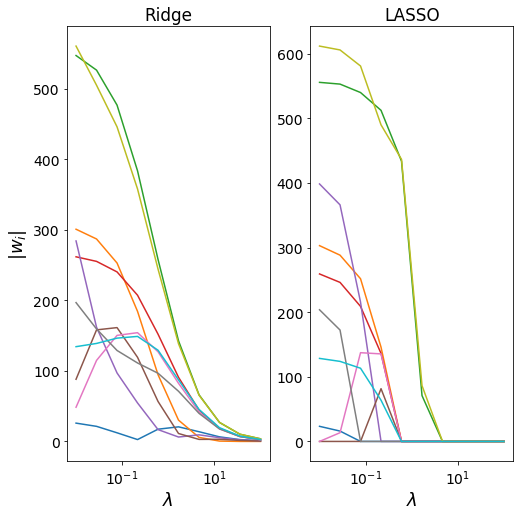

In [30]:
# First see how the 10 features we learned scale as we change the regularization parameter
# Ridge
plt.subplot(1,2,1)
plt.semilogx(lambdas, np.abs(coefs_ridge))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('$|w_i|$',fontsize=18)
plt.title('Ridge')
#plt.savefig("Ridge_sparsity_scale.pdf.pdf")

# Lasso
plt.subplot(1,2,2)
plt.semilogx(lambdas, np.abs(coefs_lasso))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
#plt.ylabel('$|\mathbf{w}|$',fontsize=18)
plt.title('LASSO')
#plt.savefig("LASSO_sparsity_scale.pdf")
plt.show()

See questions below for analysis.

Now let's look at their performances through RMSE:

Text(0.5, 1.0, 'RMSE comparison between Ridge and Lasso')

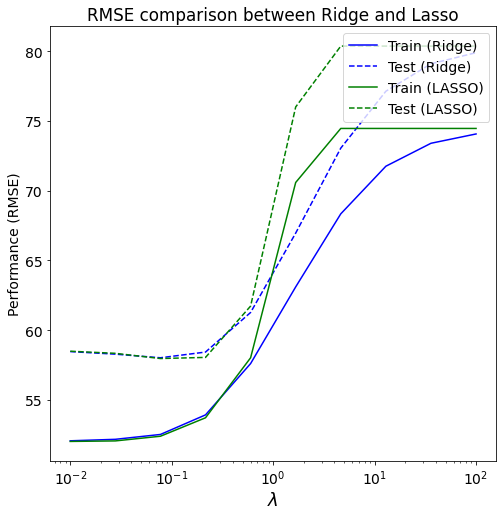

In [31]:
# Plot our performance on both the training and test data
plt.semilogx(lambdas, train_errors_ridge, 'b',label='Train (Ridge)')
plt.semilogx(lambdas, test_errors_ridge, '--b',label='Test (Ridge)')
plt.semilogx(lambdas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lambdas, test_errors_lasso, '--g',label='Test (LASSO)')
plt.legend(loc='upper right')
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('Performance (RMSE)')
#plt.savefig("Ridge_LASSO_sparsity_performance.pdf")
plt.title("RMSE comparison between Ridge and Lasso")

or through $R^2$:

Text(0.5, 1.0, '$R^2$ comparison between Ridge and Lasso')

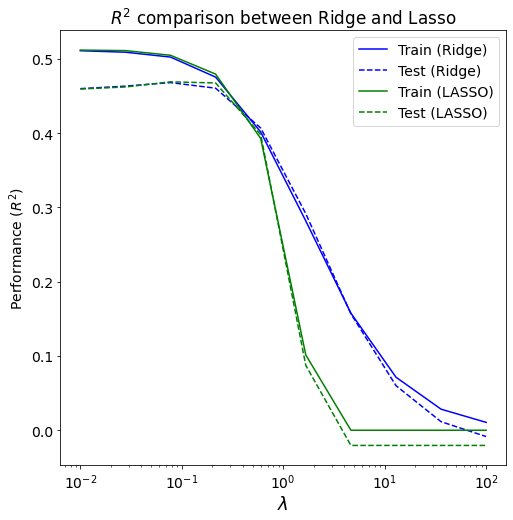

In [32]:
# Same thing with the score result
plt.semilogx(lambdas, train_scores_ridge, 'b',label='Train (Ridge)')
plt.semilogx(lambdas, test_scores_ridge, '--b',label='Test (Ridge)')
plt.semilogx(lambdas, train_scores_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lambdas, test_scores_lasso, '--g',label='Test (LASSO)')
plt.legend(loc='upper right')
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('Performance ($R^2)$')
#plt.savefig("Ridge_LASSO_sparsity_performance.pdf")
plt.title("$R^2$ comparison between Ridge and Lasso")

#### Questions


- $\lambda = 0$: the usual, un-regularized, ordinary least square linear regression
- $\lambda = 10^2$: an extremely regularized regression -- slope is $0$, which is associated with a null $R^2$ coefficient of determination on the train set. On the test set however, $R^2$ is negative which means that the regression does worse than a constant function (precisely it performs worse because the constant function used as reference in $R^2$ is the mean value of the *test* set itself, yet here we try to predict the test set using the mean value of the *training* set).
- they are two points where 'Ridge''s and 'Lasso' 's regularizers are equal.
- monotonic weights w.r.t. $\lambda$ ? We could expect all weights to decrease as $\lambda$ increases. In a way, heavily reducing a weight is like removing outlier points in a classical linear regression. By doing so, variations in the central region become more significant. Here, removing 'outlying', least significant features leaves more freedom to the remaining features's weights.

- Lasso perfoms better than Ridge over the range $[10^-2, 1]$, while Ridge does better over $[1, 10^2]$
- The plot weights w.r.t. $\lambda$ shows that for values of $\lambda$ greater than $1$, all weights are basically null -> Lasso returns a constant function that can not predict much.
- on the other part of the spectrum, we assume that clearing out the least significant features enables Lasso to predict better than its $L2$ counterpart.
- Difference between 'Lasso' and 'Ridge': Ridge never set any weight to 0, while Lasso does. Lasso is 'rougher' in this sense, but it efficiently reduces data dimensionnality by removing the least significant features.

- As the training set grows, the test scores come closer to the training set performance (that's expected)
- for small $\lambda$ and more samples (for instance 400 samples including 200 samples in the training set), Ridge performs as well as, or better than, Lasso, while remaining less bad for large $\lambda$. 
- interpretation: Lasso perfomed better when there was few data, by reducing the data dimensionality (the number of usefull features); the least features, the least data is needed for training. When more data is added, this strategy becomes less necessary and leads to information loss about the samples, hence bad results.

## Elastic Net

In [33]:
from sklearn.linear_model import ElasticNetCV

ElasticNet depends on two parameters : 
 - l1_ratio is the percentage of L1 and L2 regularization;
 - alpha is the amount of regularization 
 
`l1_ratio=1` corresponds to Lasso regularization, while `l1_ratio=0` corresponds to Ridge regularization.

In [34]:
l1_list = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 1.0]
alpha_list = np.logspace(-2, 2, 50)
en_reg = ElasticNetCV(l1_ratio=l1_list, 
                      alphas=alpha_list, 
                      random_state=52)

In [35]:
en_reg.fit(X_train, y_train)

ElasticNetCV(alphas=array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-01, 1.67683294e-01,
       2.02358965e-01, 2.44205309e-01, 2.94705170e-01, 3.55648031e-01,
       4.29193426e-01, 5.179474...
       1.93069773e+00, 2.32995181e+00, 2.81176870e+00, 3.39322177e+00,
       4.09491506e+00, 4.94171336e+00, 5.96362332e+00, 7.19685673e+00,
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02]),
             l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 1.0],
             random_state=52)

In [36]:
print(en_reg.alpha_)
print(en_reg.l1_ratio_)

0.021209508879201904
0.99


In [37]:
print(en_reg.alphas_)

[1.00000000e+02 8.28642773e+01 6.86648845e+01 5.68986603e+01
 4.71486636e+01 3.90693994e+01 3.23745754e+01 2.68269580e+01
 2.22299648e+01 1.84206997e+01 1.52641797e+01 1.26485522e+01
 1.04811313e+01 8.68511374e+00 7.19685673e+00 5.96362332e+00
 4.94171336e+00 4.09491506e+00 3.39322177e+00 2.81176870e+00
 2.32995181e+00 1.93069773e+00 1.59985872e+00 1.32571137e+00
 1.09854114e+00 9.10298178e-01 7.54312006e-01 6.25055193e-01
 5.17947468e-01 4.29193426e-01 3.55648031e-01 2.94705170e-01
 2.44205309e-01 2.02358965e-01 1.67683294e-01 1.38949549e-01
 1.15139540e-01 9.54095476e-02 7.90604321e-02 6.55128557e-02
 5.42867544e-02 4.49843267e-02 3.72759372e-02 3.08884360e-02
 2.55954792e-02 2.12095089e-02 1.75751062e-02 1.45634848e-02
 1.20679264e-02 1.00000000e-02]


ElasticNetCV reverses the list of alphas !

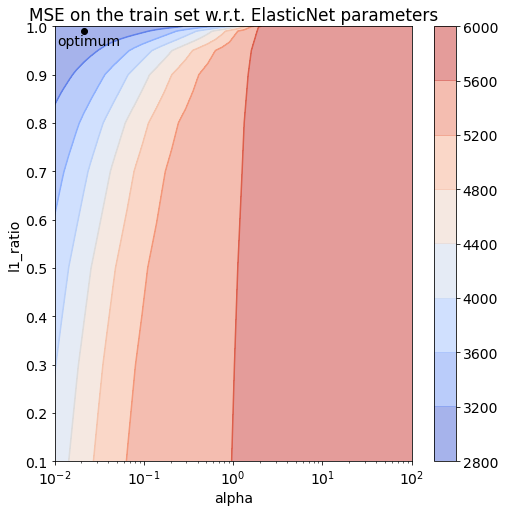

In [38]:
mse_averaged = en_reg.mse_path_.mean(axis=2)
# Plot the MSE on the training set during optimization
plt.semilogx()
plt.contour(en_reg.alphas_, l1_list, mse_averaged, cmap='coolwarm')
plt.contourf(en_reg.alphas_, l1_list, mse_averaged, cmap='coolwarm', alpha=0.5)
plt.plot(en_reg.alpha_, en_reg.l1_ratio_, marker='o', c='k')
plt.annotate("optimum", xy=(en_reg.alpha_, en_reg.l1_ratio_),
            xytext=(0.5*en_reg.alpha_, 0.97*en_reg.l1_ratio_))
plt.title("MSE on the train set w.r.t. ElasticNet parameters")
plt.xlabel("alpha")
plt.ylabel("l1_ratio")
plt.colorbar()

This plot is consistent with the values selected by ElasticNetCV for `l1_ratio` and `alpha`. We see that best results are obtained for `l1_ratio` close to 1 and small `alpha`, ie. a light Lasso regularization.

## Bonuses

### Ordinary Least Squares

We try to find a minimum of 
$$ \mathrm{L_2}(\mathbf{w}, \lambda) = \lVert \mathbf{X w} - \mathbf{y} \rVert_2^2$$
Matricially this reads as 
$ \left( \mathbf{Xw} - \mathbf{y} \right)^T \left( \mathbf{Xw} - \mathbf{y} \right)$. 
Then the formulas of matrix calculus yield 
$$ \partial_{\mathbf{w}} \left[ \mathrm{L_2} (\mathbf{w}, \lambda) \right] = 2 \mathbf{X}^T \left( \mathbf{X w} - \mathbf{y} \right)$$ 
The stationnary condition requires that 
$\mathbf{X}^T \mathbf{X} \mathbf{w} = \mathbf{X}^T \mathbf{y}$
and results in 
$$\boxed{\mathbf{w} = \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y} } $$

If $r(\mathbf{X})<p$, then the product $(\mathbf{X}^T\mathbf{X})$ is also of rank lesser than $p$ since $r(\mathbf{X}^T)=r(\mathbf{X})$. We are then dealing with a (p, p) matrix of rank $<p$, so it is not invertible and $\mathbf{w}$ is not well defined.

### Ridge

The approach is the same as above. We try to find a minimum of $$ \mathrm{L_2}(\mathbf{w}, \lambda) = \lVert \mathbf{X w} - \mathbf{y} \rVert_2^2 + \lambda \lVert \mathbf{w} \rVert_2^2.$$ Matricially this reads as $ \left( \mathbf{Xw} - \mathbf{y} \right)^T \left( \mathbf{Xw} - \mathbf{y} \right) + \lambda \mathbf{w} ^T \mathbf{w}$. Then the formulas of matrix calculus yield $$ \partial_{\mathbf{w}} \left[ \mathrm{L_2} (\mathbf{w}, \lambda) \right] = 2 \mathbf{X}^T \left( \mathbf{X w} - \mathbf{y} \right) + 2 \lambda \mathbf{w}.$$ The stationnary condition requires that $\left( \mathbf{X}^T \mathbf{X} + \lambda \mathbf{I} \right) \mathbf{w} = \mathbf{X}^T \mathbf{y}$ and results in $$\boxed{\mathbf{w} = \left( \mathbf{X}^T \mathbf{X} + \lambda \mathbf{I} \right)^{-1} \mathbf{X}^T \mathbf{y} } $$

### Lasso

The derivative of the absolute value $\lvert x \rvert$ is either $-1$, $+1$ or cannot be determined at $x=0$. Hence the L1 norm does not make it possible to find an analytic expression for $\mathbf{w}$. 

Numerical computation : LASSO uses the coordinate descent method.

- For $\lambda=0$, both Ridge and LASSO come down to the OLS regression ;
- For $\lambda=\infty$, the minimal norm both for Ridge and LASSO is reached for $\mathbf{w}=0$, whatsoever the data.

In both cases, Ridge and Lasso yield the same results.

## Conclusion

We compared the LASSO, Ridge and ElasticNet regularizers. They all tend to shrink the weight parameters to 0, which helps preventing overfitting in training. They differ by how and how fast they shrink the weights. In particular, LASSO is useful when we expect a lot of features to be irrelevant, whereas Ridge takes them all into account. ElasticNet takes the best of both worlds but requires optimizing two hyperparameters instead of one.